In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d samaarashidaarbi/dibas-bacterial-colony-dataset

import zipfile
zip_ref = zipfile.ZipFile('/content/dibas-bacterial-colony-dataset.zip', 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/samaarashidaarbi/dibas-bacterial-colony-dataset
License(s): CC0-1.0
dibas-bacterial-colony-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!pip install -Uqq fastai dill
import dill
from fastai.vision.all import *
import os
import logging
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import exposure
from PIL import Image, TiffImagePlugin, UnidentifiedImageError

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 67.2 MB/s eta 0:00:00


# New Section

In [ ]:

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

DATA_PATH = Path("/content/dataset")
MODEL_PATH = Path("/content/model")
MODEL_NAME = "microlens_classifier.pkl"
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3

MODEL_PATH.mkdir(exist_ok=True)

def preprocess_image(img: Image.Image) -> Image.Image:
    img_array = np.array(img)
    img_adapteq = exposure.equalize_adapthist(img_array, clip_limit=0.03)
    img_adapteq = (img_adapteq * 255).astype(np.uint8)
    return Image.fromarray(img_adapteq)

def get_image(fname):
    try:
        TiffImagePlugin.READ_LIBTIFF = True
        img = Image.open(fname).convert('RGB')
        return preprocess_image(img)
    except Exception as e:
        print(f"Error loading image {fname}: {str(e)}")
        return None

def label_func(fname):
        return fname.split('_')[0]

def get_dls(path: Path, image_size=(224, 224), batch_size=32) -> DataLoaders:

    return ImageDataLoaders.from_name_func(
        path,
        get_image_files(path),
        valid_pct=0.2,
        seed=42,
        label_func=label_func,
        item_tfms=Resize(image_size),
        batch_tfms=[
            *aug_transforms(
                mult=1.0,
                do_flip=True,
                flip_vert=True,
                max_rotate=10.0,
                min_zoom=1.0,
                max_zoom=1.1,
                max_lighting=0.2,
                max_warp=0.2,
                p_affine=0.75,
                p_lighting=0.75,
            ),
            Normalize.from_stats(*imagenet_stats)
        ],
        bs=batch_size
    )

def create_learner(dls: DataLoaders, path: Path) -> Learner:
    return cnn_learner(
        dls,
        densenet121,
        metrics=[error_rate, accuracy, F1Score(average='weighted')],
        cbs=[
            MixUp(),
            SaveModelCallback(monitor='valid_loss', comp=np.less, fname='best_model'),
            ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2),
            EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=3),
            ShowGraphCallback()
        ],
        pretrained=True
    )

def train_model(learn: Learner, epochs: int, lr: float, freeze_epochs: int = 3) -> None:
    learn.fine_tune(epochs, lr, freeze_epochs=freeze_epochs)

def save_model(learn: Learner) -> None:
    learn.export(MODEL_PATH/MODEL_NAME)

def load_model() -> Learner:
    return load_learner(MODEL_PATH/MODEL_NAME)

def plot_results(learn: Learner):
    learn.recorder.plot_loss()
    plt.title('Training and Validation Loss')
    plt.tight_layout()
    plt.show()

    learn.recorder.plot_metrics()
    plt.title('Training and Validation Metrics')
    plt.tight_layout()
    plt.show()

    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix(figsize=(10,10))
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    interp.plot_top_losses(9, figsize=(15,11))
    plt.tight_layout()
    plt.show()

def train_and_visualize():
    print(f"Loading data from {DATA_PATH}")
    dls = get_dls(DATA_PATH)

    print(f"Number of training batches: {len(dls.train)}")
    print(f"Number of validation batches: {len(dls.valid)}")

    if len(dls.train) == 0 or len(dls.valid) == 0:
        print("DataLoader is empty. Please check your dataset and data loading process.")
        return

    print("Showing a batch of images:")
    dls.show_batch()

    learn = create_learner(dls, MODEL_PATH)
    print("Starting model training...")
    train_model(learn, EPOCHS, LEARNING_RATE)
    print("Training completed. Plotting results...")
    plot_results(learn)
    print(f"Saving model to {MODEL_PATH / MODEL_NAME}")
    save_model(learn, MODEL_PATH / MODEL_NAME)
    print("Model saved successfully.")


def predict_and_visualize(image_path: str):
    learn = load_learner(MODEL_PATH / MODEL_NAME)

    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    img = preprocess_image(img)

    # Perform prediction
    pred_class, pred_idx, probs = learn.predict(img)

    # Check if the class vocab is correctly loaded
    if not learn.dls.vocab:
        print("Error: The vocabulary (class labels) is empty.")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(img)
    ax1.set_title("Original Image")
    ax1.axis('off')

    ax2.bar(range(len(probs)), probs)
    ax2.set_title("Prediction Probabilities")
    ax2.set_xticks(range(len(probs)))
    ax2.set_xticklabels(learn.dls.vocab, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    pred_label = learn.dls.vocab[pred_idx] if pred_idx is not None else 'Unknown'
    confidence = probs[pred_idx] if pred_idx is not None else 0.0

    print(f"Predicted class: {pred_label}")
    print(f"Confidence: {confidence:.2%}")

    return pred_label, confidence



/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time
0,4.813943,3.052132,0.891473,0.108527,0.102079,00:28
1,3.967958,1.243135,0.279070,0.720930,0.700449,00:27
2,3.152716,0.543854,0.139535,0.860465,0.852996,00:29


Better model found at epoch 0 with valid_loss value: 3.0521321296691895.


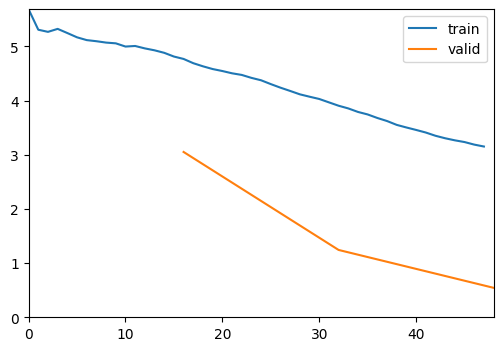

Better model found at epoch 1 with valid_loss value: 1.243134617805481.
Better model found at epoch 2 with valid_loss value: 0.5438544750213623.


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time
0,1.863203,0.440278,0.108527,0.891473,0.895631,00:27
1,1.829993,0.359276,0.100775,0.899225,0.901945,00:28
2,1.818718,0.295867,0.077519,0.922481,0.923360,00:27
3,1.781151,0.241362,0.077519,0.922481,0.925323,00:27
4,1.713501,0.206365,0.054264,0.945736,0.947832,00:31
5,1.645245,0.164577,0.038760,0.961240,0.962415,00:27
6,1.604934,0.221675,0.046512,0.953488,0.955239,00:26
7,1.591810,0.170666,0.038760,0.961240,0.962514,00:29
8,1.567609,0.164873,0.038760,0.961240,0.962326,00:27


Better model found at epoch 0 with valid_loss value: 0.4402780830860138.


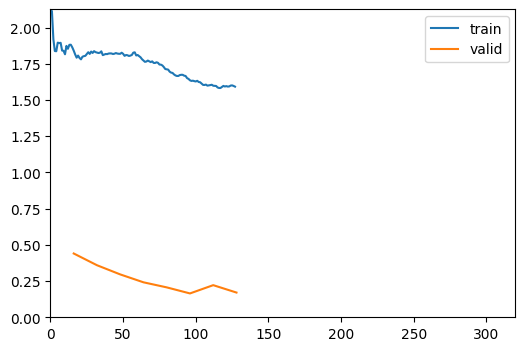

Better model found at epoch 1 with valid_loss value: 0.35927557945251465.
Better model found at epoch 2 with valid_loss value: 0.295867383480072.
Better model found at epoch 3 with valid_loss value: 0.2413620948791504.
Better model found at epoch 4 with valid_loss value: 0.20636528730392456.
Epoch 4: reducing lr to 4.69840423120973e-05
Better model found at epoch 5 with valid_loss value: 0.16457675397396088.
Epoch 7: reducing lr to 4.767415558588772e-05
No improvement since epoch 5: early stopping
Training completed.


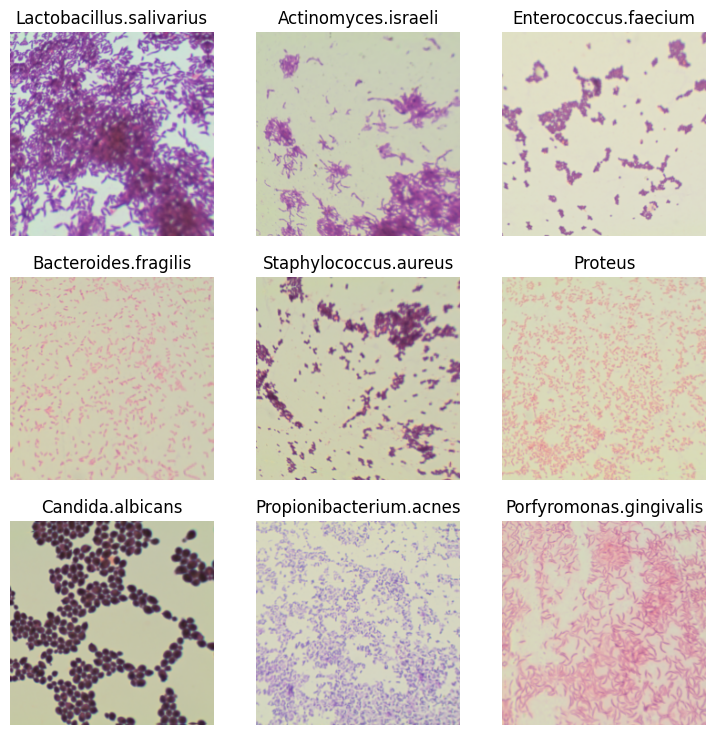

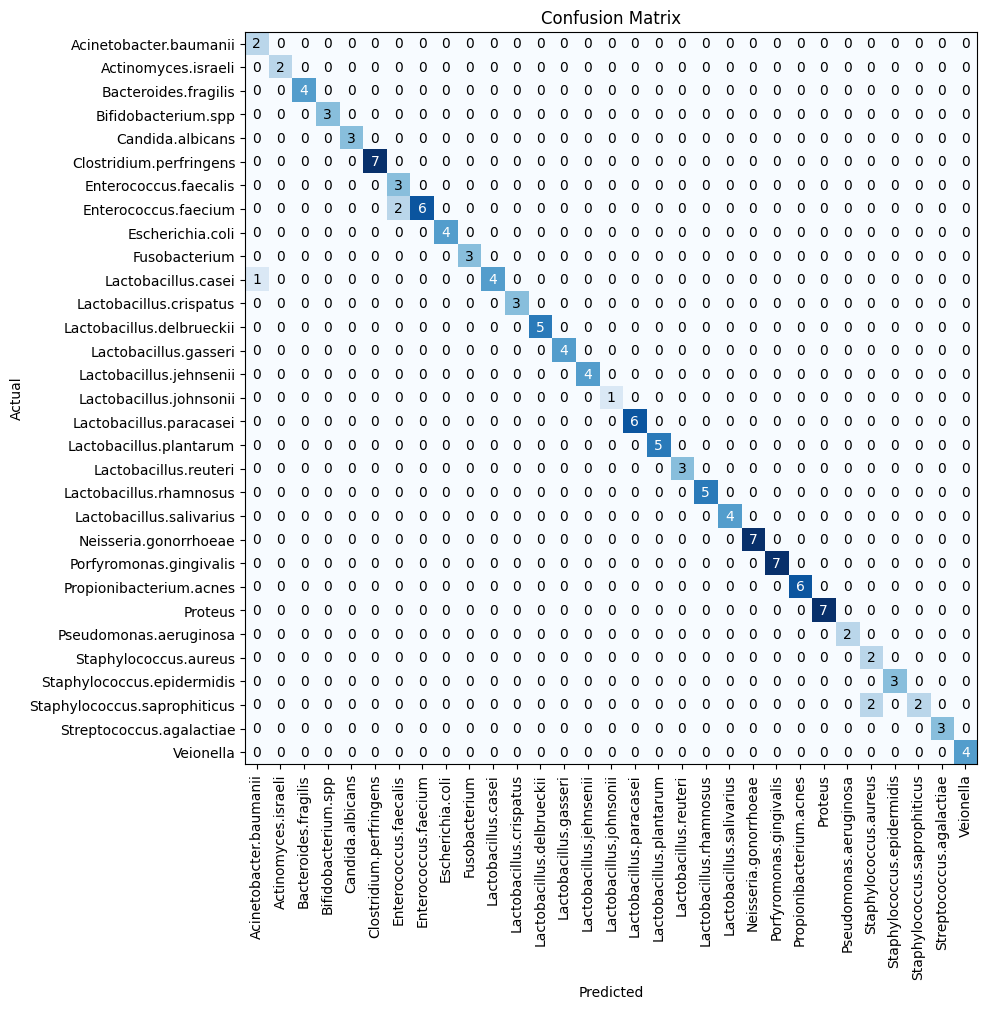

In [ ]:
#trainer
dls = get_dls(DATA_PATH)
dls.show_batch()
learn = create_learner(dls, MODEL_PATH)

train_model(learn, EPOCHS, LEARNING_RATE)
print("Training completed.")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10))
plt.title('Confusion Matrix')
plt.show()



In [ ]:
print(f"Saving model to {MODEL_PATH / MODEL_NAME}")
save_model(learn)
print("Model saved successfully.")

Saving model to /content/model/microlens_classifier.pkl
Model saved successfully.


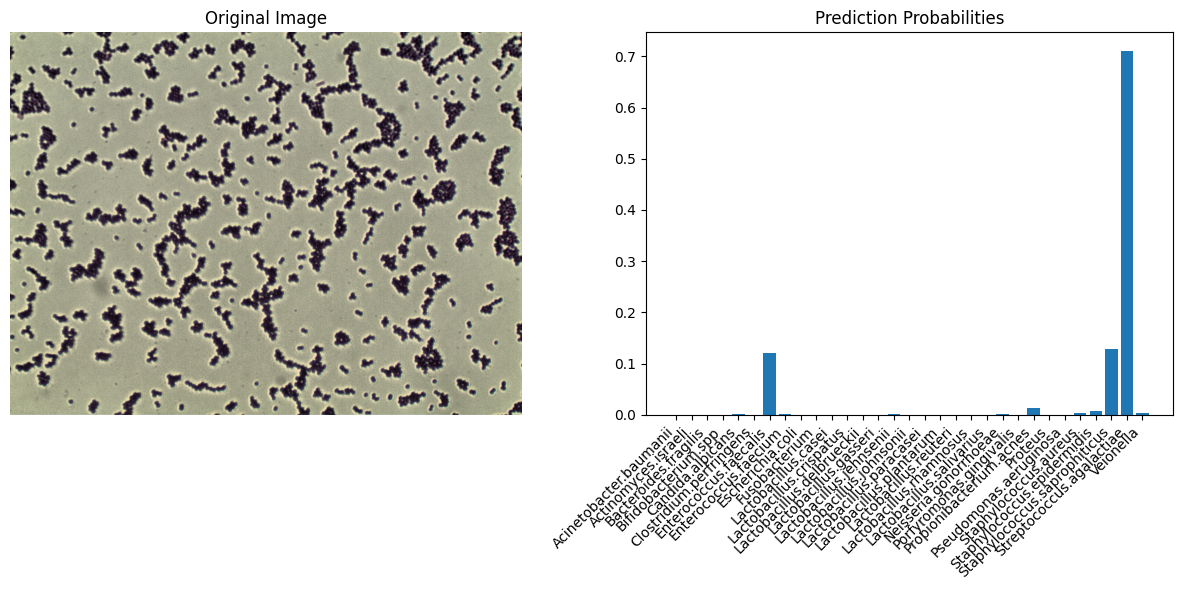

Predicted class: Streptococcus.agalactiae
Confidence: 71.12%


('Streptococcus.agalactiae', tensor(0.7112))

In [ ]:
predict_and_visualize('/content/dataset/Streptococcus.agalactiae/Streptococcus.agalactiae_0001.tif')